In [1]:
# imports
import sys 
import random
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 
import matplotlib.cbook as cbook 
plt.rcParams.update({'font.size': 12}) 
import mpld3 
import ast
#import ROOT
import uproot3 as ur3
import uproot as ur4
import pandas as pd 
from tqdm import tqdm 
from scipy.optimize import curve_fit 
from scipy import stats
from scipy.signal import lfilter, filtfilt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import scipy.integrate as integrate
from lmfit import Model
import threading
from pathlib import Path
from matplotlib import gridspec
import datetime
import matplotlib.ticker as mticker
import time
import pathlib
import awkward as ak
import pprint
import pickle
import struct
from os.path import exists

In [2]:
RootDictonary = {}

In [3]:
def GetRunData(run):
    RootDictonary.update({run:{}})
    file_path = "../FilterData/"+str(run)+"/Analysis.root"

    file = ur4.open(file_path)
    keys_file = file.keys()

    MatchLib = {}
    for key_file in keys_file:
        if "GlobalTimeStamp" in key_file:
            _, key_file_index = key_file.split(";")
            tree = file[key_file]
            LAPPD_ID = tree["LAPPDID"]
            if len(LAPPD_ID.array())>0:
                MatchLib[key_file_index] = LAPPD_ID.array()[0]

    for key_file in keys_file:
        _, key_file_index = key_file.split(";")
        tree = file[key_file]
        keys_tree = tree.keys()
        for key_tree in keys_tree:
            branch = tree[key_tree]
            if MatchLib[key_file_index] not in RootDictonary[run]:
                RootDictonary[run].update({MatchLib[key_file_index]:{key_tree:np.array(branch.array())}})
            else:
                RootDictonary[run][MatchLib[key_file_index]][key_tree] = np.array(branch.array())


def PlotSingleBeamPlot(run_array,run,savelocation,binwidth): #needs RootDictonary[run][ID]["DeltaT_TimeStamp"]
    timestamp_beam_psec=run_array

    fig = plt.figure(0, figsize=[15,10], facecolor='white') 
    if run==4248 or run==4249 or run==4250:
        labelval = "R-{}, LAPPD 63 ,entries={}".format(run,len(timestamp_beam_psec))
    else:
        labelval = "R-{}, LAPPD 40 ,entries={}".format(run,len(timestamp_beam_psec))
    plt.hist(timestamp_beam_psec,bins=np.arange(min(timestamp_beam_psec), max(timestamp_beam_psec) + binwidth, binwidth),label=labelval,histtype='stepfilled',alpha=0.8,log=False,color='blue')
    plt.xlabel("time difference between event timestamp and beamgate timestamp in ns")
    plt.ylabel("event/{}ns".format(binwidth))
    plt.legend()
    plt.savefig(savelocation+"SingleBeamPlot_R{}.png".format(run), bbox_inches='tight', pad_inches = 0.5)
    plt.close()

def PlotSinglePPSTimestamp(run_array,run,savelocation,binwidth,cutoff): #needs RootDictonary[run][ID]["PPSTimeEvolution"]
    timestamp_pps = run_array
    timestamp_pps = timestamp_pps[timestamp_pps<cutoff] 

    fig = plt.figure(0, figsize=[15,10], facecolor='white') 
    if run==4248 or run==4249 or run==4250:
        labelval = "R-{}, LAPPD 63, entries={}".format(run,len(timestamp_pps))
    else:
        labelval = "R-{}, LAPPD 40, entries={}".format(run,len(timestamp_pps))
    plt.hist(timestamp_pps,bins=np.arange(min(timestamp_pps), max(timestamp_pps) + binwidth, binwidth),label=labelval,histtype='stepfilled',alpha=0.8,log=True,color='blue')
    plt.xlabel("time difference between pps timestamps in s")
    plt.ylabel("event/{}s".format(binwidth))
    plt.xlim([0,cutoff])
    plt.legend()
    plt.savefig(savelocation+"SinglePPSTimestamp_R{}.png".format(run), bbox_inches='tight', pad_inches = 0.5)
    plt.close()


def EmergencyBreakInPPS(run_array,run,savelocation,binwidth): #needs RootDictonary[run][ID]["PPS_TimeStamp"]
    rundata = run_array/320e6

    list_of_dataparts = []
    tmp_list = []
    for enum in range(0,len(rundata)-1):
        if rundata[enum+1]<rundata[enum]:
            list_of_dataparts.append(tmp_list)
            tmp_list = []
        else:
            tmp_list.append(rundata[enum])

    fig = plt.figure(0, figsize=[10,10], facecolor='white') 
    if run==4248 or run==4249 or run==4250:
        labelval = "R-{}, LAPPD 63, entries={}".format(run,len(rundata))
    else:
        labelval = "R-{}, LAPPD 40, entries={}".format(run,len(rundata))
    for datapart in list_of_dataparts:
        plt.hist(datapart,bins=np.arange(min(datapart), max(datapart) + binwidth, binwidth),histtype='stepfilled',alpha=0.8,log=True,color='blue')
        plt.xlabel("pps timestamps in s")
        plt.ylabel("event/{}s".format(binwidth))
    #plt.legend(labelval)
    plt.savefig(savelocation+"PPSTimestampHistogram_R{}.png".format(run), bbox_inches='tight', pad_inches = 0.5)
    plt.close()

    
def FindPPSValue(data,binwidth):
    hist, bin_edges = np.histogram(data,bins=np.arange(min(data), max(data) + binwidth, binwidth))
    
    retval = (bin_edges[np.where(hist==np.max(hist))])
    if retval>9 and retval<11:
        return 10
    if retval>0 and retval <2:
        return 1 


def FindSimilarTimeStamps(run_array,run,limit): #needs RootDictonary[run][ID]["PPS_TimeStamp"]
    array = run_array/320e6
    for en1,entry in enumerate(array):
        for en2,loop in enumerate(array):
            if np.fabs(entry-loop)<=limit and en1!=en2:
                print("Entry {} with {} is the same as entry {} with {}".format(en1,entry,en2,loop))


def Plot_PPS_RPi_TimeDifference(run_array,run,savelocation,binwidth): #needs RootDictonary[run][ID]["PPS_RPi_dt"]
    dt = run_array
    dt = (dt - dt[0])*1e-9

    fig = plt.figure(0, figsize=[10,10], facecolor='white')
    if run==4248 or run==4249 or run==4250:
        labelval = "R-{}, LAPPD 63, entries={}".format(run,len(dt))
    else:
        labelval = "R-{}, LAPPD 40, entries={}".format(run,len(dt)) 
    plt.hist(dt,bins=np.arange(min(dt), max(dt) + binwidth, binwidth),label=labelval,histtype='stepfilled',alpha=0.8,log=False,color='blue')
    plt.xlabel("Delta t between pps and rpi timestamp in s")
    plt.ylabel("event/{}s".format(binwidth))
    plt.legend()
    plt.savefig(savelocation+"PPS_RPi_DT_R{}.png".format(run), bbox_inches='tight', pad_inches = 0.5)
    plt.close()


def PlotPPSHistogram(run_array,run,savelocation,binwidth): #needs RootDictonary[run][ID]["PPS_TimeStamp"]
    timestamp_pps = run_array/320e6

    for enum in range(0,len(timestamp_pps)-1):
        if(timestamp_pps[enum+1]<timestamp_pps[enum]):
            EmergencyBreakInPPS(run_array,run,savelocation,binwidth)
            return

    fig = plt.figure(0, figsize=[10,10], facecolor='white') 
    if run==4248 or run==4249 or run==4250:
        labelval = "R-{}, LAPPD 63, entries={}".format(run,len(timestamp_pps))
    else:
        labelval = "R-{}, LAPPD 40, entries={}".format(run,len(timestamp_pps))
    plt.hist(timestamp_pps,bins=np.arange(min(timestamp_pps), max(timestamp_pps) + binwidth, binwidth),label=labelval,histtype='stepfilled',alpha=0.8,log=True,color='blue')
    plt.xlabel("pps timestamps in s")
    plt.ylabel("event/{}s".format(binwidth))
    plt.legend()
    plt.savefig(savelocation+"PPSTimestampHistogram_R{}.png".format(run), bbox_inches='tight', pad_inches = 0.5)
    plt.close()


In [ ]:
run_list = [4358]
ID = 0
for run in run_list:
    try:
        if run not in RootDictonary:
            GetRunData(run)
    except Exception as e:
        print("Failed to load run {} with {}".format(run,e))

    PlotSingleBeamPlot(RootDictonary[run][ID]["DeltaT_TimeStamp"],run,"../FilterData/{}/".format(run),125)
    PlotSinglePPSTimestamp(RootDictonary[run][ID]["PPSTimeEvolution"],run,"../FilterData/{}/".format(run),1,50)
    #PlotPPSHistogram(RootDictonary[run][ID]["PPS_TimeStamp"],run,"../FilterData/{}/".format(run),10)
    Plot_PPS_RPi_TimeDifference(RootDictonary[run][ID]["PPS_RPi_dt"],run,"../FilterData/{}/".format(run),1e-3)

#GetRunTypePlot(run_list)
FindSimilarTimeStamps(RootDictonary[run][ID]["PPS_TimeStamp"],run,0)

pprint.pprint(RootDictonary[run_list[0]].keys())

In [ ]:
run = 4356
GetRunData(run)
LAPPD_ID = 0

fig, ax1 = plt.subplots(figsize=[20,10], facecolor='white') 
ax1.plot(RootDictonary[run][LAPPD_ID]["PPSinDelta"])
ax1.set_xlabel("Event #")
ax1.set_ylabel("PPS dt between ACDCs on the same LAPPD in 320MHz clockcycle counts")

ax2 = ax1.twinx()  
ax2.plot(RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"],'xr')
ax2.set_ylabel("PPS timestamp")
plt.title("R"+str(run))


In [ ]:
run_list = [4376]
timeratio = {}
for run in run_list:
    timeratio.update({run:[]})
    fig = plt.figure(run, figsize=[20,10], facecolor='white')
    plt.title("R"+str(run))
    GetRunData(run)

    pps_value = FindPPSValue(RootDictonary[run][0]["PPSTimeEvolution"],0.5)

    if len(RootDictonary[run])==1:
        print("Single LAPPD run")
        limit_for_timeout = 4*pps_value
    elif len(RootDictonary[run])==2:
        print("Double LAPPD run")
        limit_for_timeout = 3.5*pps_value
    else:
        print("AHHHHHHHHHHHH")

    try:
        LAPPD_ID = 0
        data = RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"]/320e6
        dt = []
        timeouts = 0
        for i_entry in range(0,len(data)-1):
            dt_val = data[i_entry+1]-data[i_entry]
            if dt_val < 0:
                timeouts += 1
            else:
                dt.append(dt_val)
        plt.plot(dt,label="LAPPD-ID: {}, entries={}, timeouts={:.5f}".format(LAPPD_ID,len(dt),timeouts))
        timeratio[run].append(timeouts/len(RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"]))
    except:
        pass
    try:
        LAPPD_ID = 2
        data = RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"]/320e6
        dt = []
        timeouts = 0
        for i_entry in range(0,len(data)-1):
            dt_val = data[i_entry+1]-data[i_entry]
            if dt_val < 0:
                timeouts += 1
            else:
                dt.append(dt_val)
        plt.plot(dt,label="LAPPD-ID: {}, entries={}, timeouts={:.5f}".format(LAPPD_ID,len(dt),timeouts))
        timeratio[run].append(timeouts/len(RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"]))
    except: 
        pass
    plt.legend(loc='upper right')

xlist=[]
ylist=[]

for run in run_list:
    for entry in timeratio[run]:
        xlist.append(run)
        ylist.append(entry)

fig = plt.figure(0, figsize=[20,10], facecolor='white')
plt.plot(xlist,ylist,'x')


In [ ]:
GetRunData(4399)
data = RootDictonary[4399][1]["PPS_TimeStamp"]/320e6
dt=[]
fig = plt.figure(0, figsize=[20,10], facecolor='white')
for d in range(0,len(data)-1):
    if(data[d]<data[d+1]):
        dt.append(data[d+1]-data[d])

plt.plot(dt)

In [ ]:
GetRunData(4399)
data = RootDictonary[4399][0]["PPS_Counter"]#
data1 = RootDictonary[4399][1]["PPS_Counter"]#
data2 = RootDictonary[4399][2]["PPS_Counter"]#
fig = plt.figure(0, figsize=[20,10], facecolor='white')
plt.plot(data)
plt.plot(data1,'r')
plt.plot(data2)
#plt.xlim([0,1000])
for id in range(0,len(data)-1):
    if(data[id]==data[id+1]):
        print("{} and {} were double".format(id,id+1))
    # if(data[id+1]<=data[id]):
    #     plt.axvline(x=id,c='r',ls='-.')
    # if(data[id+1]-data[id]>2):
    #     plt.axvline(x=id,c='b',ls='--')


In [ ]:
run_list = [4400]
timeratio = {}
for run in run_list:
    timeratio.update({run:[]})
    fig, (ax1, ax2) = plt.subplots(2, 1, facecolor='white',sharex=True, figsize=(20,10))
    fig.suptitle('Run R{}'.format(run))
    fig.subplots_adjust(hspace=0)

    GetRunData(run)

    if len(RootDictonary[run])==1:
        print("Single LAPPD run")
    elif len(RootDictonary[run])==2:
        print("Double LAPPD run")
    elif len(RootDictonary[run])==3:
        print("Triple LAPPD run")
    else:
        print("AHHHHHHHHHHHH")

    for id in [0,1,2]:
        LAPPD_ID = id
        data = RootDictonary[run][LAPPD_ID]["PPS_TimeStamp"]/320e6
        data = np.delete(data,[0,1])

        print("Data for ID-{} has {} entries".format(LAPPD_ID,len(data)))

        dt = []
        timeouts = 0
        for i_entry in range(0,len(data)-1):
            dt_val = data[i_entry+1]-data[i_entry]
            if dt_val < 0:
                timeouts += 1
            else:
                dt.append(10-dt_val)
        data_ppsc = RootDictonary[run][LAPPD_ID]["PPS_Counter"]
        data_ppsc = np.delete(data_ppsc,[0,1])

        colors = ['blue','green','orange']
        ax1.plot(dt,c=colors[LAPPD_ID],label="Clockdrift LAPPD-ID: {}, entries={}, timeouts={}".format(LAPPD_ID,len(dt),timeouts)) 
        ax1.set_ylabel("Clockdrift in s")
        ax1.set_ylim([2e-5,7.5e-5])

        ax2.plot(data_ppsc,c=colors[LAPPD_ID],label="PPS Counter LAPPD-ID: {}, entries={}".format(LAPPD_ID,len(data_ppsc)))
        ax2.set_ylabel("PPS counter")
        ax2.set_xlabel('Event')

    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')


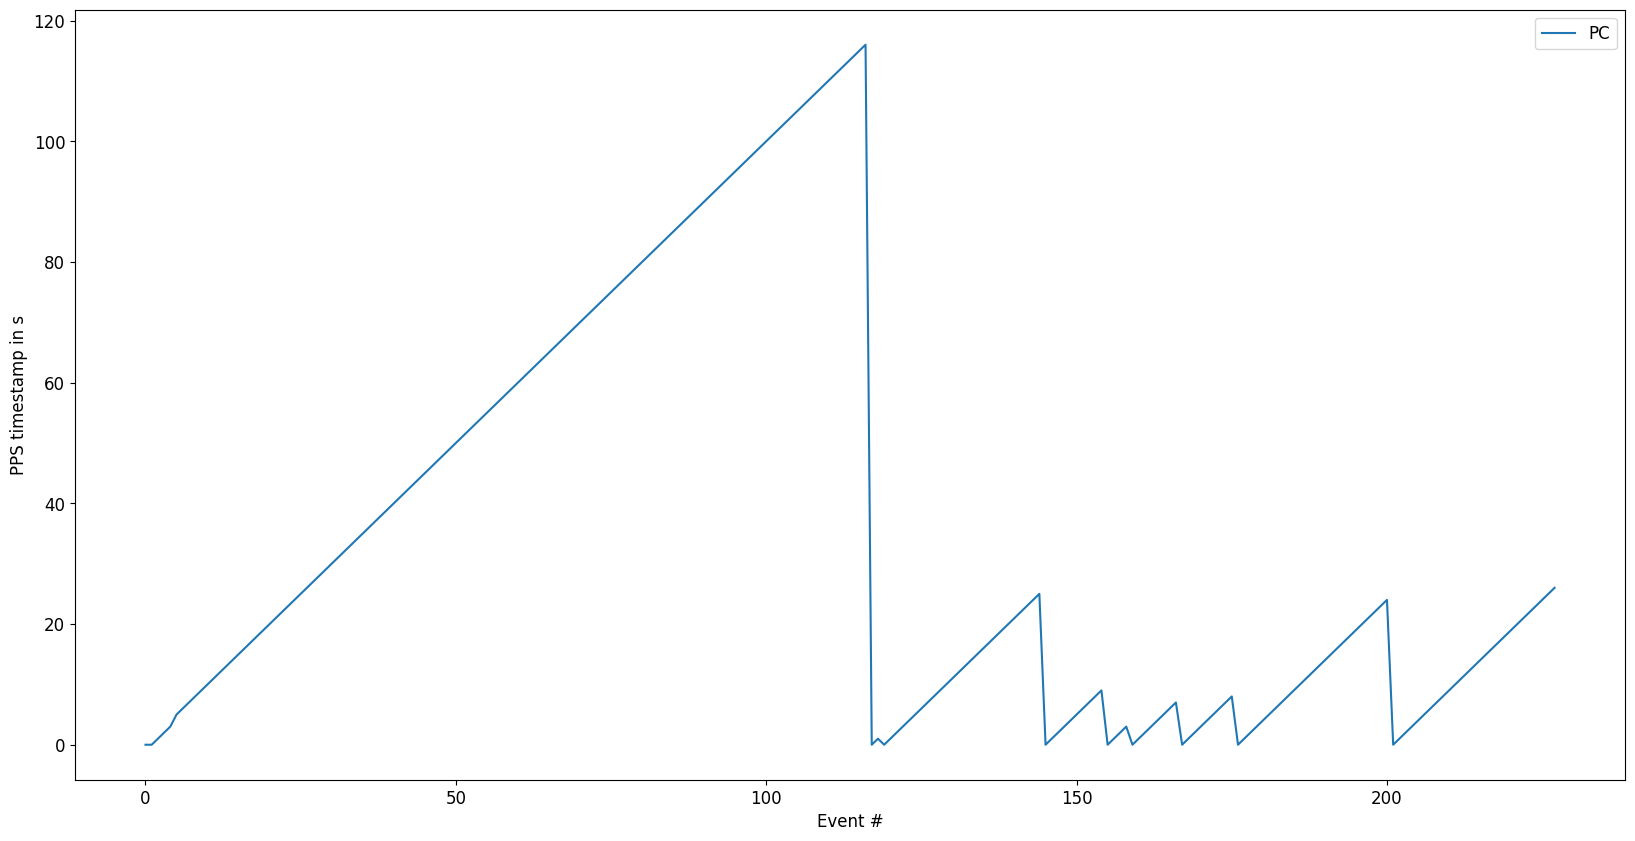

In [26]:
run_list = [4399]
timeratio = {}
for run in run_list:
    fig = plt.figure(0, figsize=[20,10], facecolor='white')
    GetRunData(run)
    #plt.plot(RootDictonary[run][1]["PPS_TimeStamp"]/320e6,'.',label='TS')
    plt.plot(RootDictonary[run][0]["PPS_Counter"],label='PC')
    #plt.xlim([900,1300])
    plt.xlabel("Event #")
    plt.legend()
    plt.ylabel("PPS timestamp in s")